<a href="https://colab.research.google.com/github/siddharth3444/detect_window/blob/main/Model_Training_loop_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets -qq
!pip install evaluate -qq
!pip install albumentations -qq
!pip install git+https://github.com/huggingface/transformers.git -qq
# We will use this to push our trained model to HF Hub
!pip install huggingface_hub -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 783.7 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation,
)
import evaluate
from huggingface_hub import notebook_login

In [18]:
from datasets import load_dataset
ds = load_dataset("mukesh3444/manual-window-detect")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 7
    })
    test: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 2
    })
    validation: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 2
    })
})


In [19]:
from datasets import load_dataset
train = load_dataset("scene_parse_150", "instance_segmentation", split="train")
validation = load_dataset("scene_parse_150", "instance_segmentation", split="validation")
test = load_dataset("scene_parse_150", "instance_segmentation", split="test")

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [268]:
checkpoint = "facebook/maskformer-swin-base-ade"
print(validation)

Dataset({
    features: ['image', 'annotation'],
    num_rows: 2000
})


In [271]:
from transformers import MaskFormerFeatureExtractor
processor2 = MaskFormerImageProcessor.from_pretrained(checkpoint)
processor2 = MaskFormerImageProcessor(
    reduce_labels=True,
    size=(512, 512),
    ignore_index=255,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)

# print(processo2r)
print(processor2)
processor2.do_resize=False
processor2.do_rescale=False
processor2.do_normalize=False

MaskFormerImageProcessor {
  "_max_size": 1333,
  "do_normalize": false,
  "do_reduce_labels": true,
  "do_rescale": false,
  "do_resize": false,
  "ignore_index": 255,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "MaskFormerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  },
  "size_divisor": 32
}



/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:410: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:417: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:428: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [272]:
train[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>}

In [27]:
#index = random.randint(0, len(train))

ds

index = 3
image = ds[index]["image"]
image = np.array(image.convert("RGB"))
annotation = ds[index]["annotation"]
annotation = np.array(annotation)
print(np.unique(annotation))

# plt.figure(figsize=(15, 5))
# plt.imshow(annotation.shape)

# print(annotation.shape)
# print(np.unique(annotation[..., 0]))
# print(np.unique(annotation[..., 1]))
# print(np.unique(annotation[..., 2]))
# plt.figure(figsize=(15, 5))
# for plot_index in range(3):
#     if plot_index == 0:
#         # If plot index is 0 display the original image
#         plot_image = image
#         title = "Original"
#     else:
#         # Else plot the annotation maps
#         plot_image = annotation[..., plot_index - 1]
#         title = ["Class Map (R)", "Instance Map (G)"][plot_index - 1]
#     # Plot the image
#     plt.subplot(1, 3, plot_index + 1)
#     plt.imshow(plot_image)
#     plt.title(title)
#     plt.axis("off")

KeyError: "Invalid key: 3. Please first select a split. For example: `my_dataset_dictionary['train'][3]`. Available splits: ['test', 'train', 'validation']"

[ 0  2  3  9 16 25 30 57 61]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


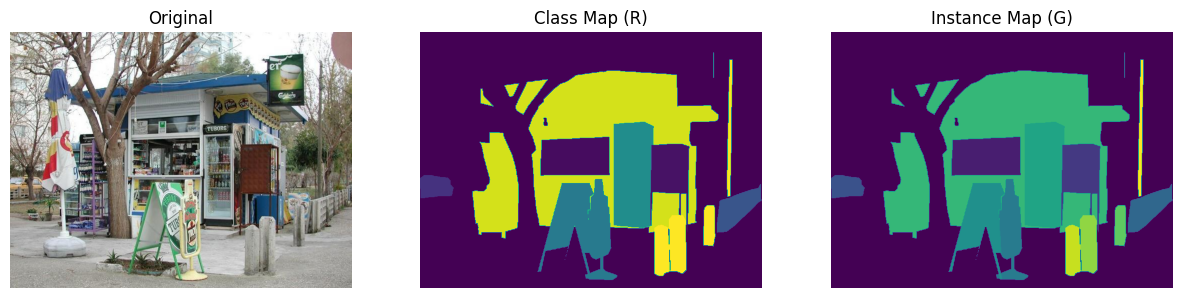

In [26]:
index = random.randint(0, len(train))
index = 3
image = train[index]["image"]
image = np.array(image.convert("RGB"))
annotation = train[index]["annotation"]
annotation = np.array(annotation)
print(np.unique(annotation[:,:,0]))
print(np.unique(annotation[:,:,1]))
# print(np.unique(annotation[..., 0]))
# print(np.unique(annotation[..., 1]))
# print(np.unique(annotation[..., 2]))
plt.figure(figsize=(15, 5))
for plot_index in range(3):
    if plot_index == 0:
        # If plot index is 0 display the original image
        plot_image = image
        title = "Original"
    else:
        # Else plot the annotation maps
        plot_image = annotation[..., plot_index - 1]
        title = ["Class Map (R)", "Instance Map (G)"][plot_index - 1]
    # Plot the image
    plt.subplot(1, 3, plot_index + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis("off")

In [274]:
from transformers import MaskFormerConfig
config = MaskFormerConfig.from_pretrained(checkpoint)

In [275]:
config = MaskFormerConfig.from_pretrained(checkpoint)
print("[INFO] displaying the MaskFormer configuration...")
print(config)

[INFO] displaying the MaskFormer configuration...
MaskFormerConfig {
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "depths": [
      2,
      2,
      18,
      2
    ],
    "drop_path_rate": 0.3,
    "embed_dim": 128,
    "hidden_size": 1024,
    "image_size": 384,
    "in_channels": 3,
    "model_type": "swin",
    "num_heads": [
      4,
      8,
      16,
      32
    ],
    "out_features": [
      "stage4"
    ],
    "out_indices": [
      4
    ],
    "path_norm": true,
    "pretrain_img_size": 384,
    "window_size": 12
  },
  "ce_weight": 1.0,
  "cross_entropy_weight": 1.0,
  "decoder_config": {
    "max_position_embeddings": 1024,
    "model_type": "detr",
    "scale_embedding": false
  },
  "dice_weight": 1.0,
  "fpn_feature_size": 256,
  "id2label": {
    "0": "wall",
    "1": "building",
    "2": "sky",
    "3": "floor",
    "4": "tree",
    "5": "ceiling",
    "6": "road, route",
    "7": "bed",
    "8": "window ",
    "9": "g

In [276]:
!wget https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
# Get a modified version of the id2label and label2id
data = pd.read_csv(
    "/content/instanceInfo100_train.txt",
    sep="\t",
    header=0,
    on_bad_lines="skip",
)
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}
label2id = {v: k for k, v in id2label.items()}
# Edit MaskFormer config labels
config.id2label = id2label
config.label2id = label2id

--2024-01-15 18:14:25--  https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3313 (3.2K) [text/plain]
Saving to: ‘instanceInfo100_train.txt.9’

instanceInfo100_tra 100%[===================>]   3.24K  --.-KB/s    in 0s      

2024-01-15 18:14:25 (32.0 MB/s) - ‘instanceInfo100_train.txt.9’ saved [3313/3313]



In [277]:
model = MaskFormerForInstanceSegmentation(config)
# Replace the randomly initialized model with the pre-trained model weights
base_model = MaskFormerModel.from_pretrained(checkpoint)
model.model = base_model

In [278]:
# Define the configurations of the transforms specific
# to the dataset used
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# print(ADE_MEAN,ADE_STD)
# Build the augmentation transforms
train_val_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# ================================================================================================================================================================================================================================================
# idx=3
# image = np.array(train[idx]["image"].convert("RGB"))
# instance_seg = np.array(train[idx]["annotation"])[..., 1]
# class_id_map = np.array(train[idx]["annotation"])[..., 0]
# class_labels = np.unique(class_id_map)
# print(class_labels)

# inst2class = {}

# for label in class_labels:
#       instance_ids = np.unique(instance_seg[class_id_map == label])
#       inst2class.update({i: label for i in instance_ids})
# print(class_labels.shape[0])
# print(inst2class)


# print(inst2class)

# transformed = train_val_transform(image=image, mask=instance_seg)
# (image, instance_seg) = (transformed["image"], transformed["mask"])

# plt.figure(figsize=(15, 5))
# plt.imshow(image)
# plt.figure(figsize=(15, 5))
# plt.imshow(instance_seg)


# print((image, instance_seg))

# inputs = processor(
#               [image],
#               [instance_seg],
#               instance_id_to_semantic_id=inst2class,
#               return_tensors="pt"
# )


# # inputs = {
# #     k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()
# # }
# print(inputs)


# # # # Convert from channels last to channels first
# # image = image.transpose(2,0,1)

# # inputs = processor([image], return_tensors="pt")
# # inputs = {k:v.squeeze() for k,v in inputs.items()}
# # inputs["class_labels"] = torch.tensor([0])
# # inputs["mask_labels"] = torch.zeros(
# #     (0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1])
# # )
# =================================================================================================================================================================================================================================

class ImageSegmentationDataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        # Initialize the dataset, processor, and transform variables
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        # Return the number of datapoints
        return len(self.dataset)

    def __getitem__(self, idx):
        # Convert the PIL Image to a NumPy array
        image = np.array(self.dataset[idx]["image"].convert("RGB"))

        # Get the pixel wise instance id and category id maps
        # of shape (height, width)
        instance_seg = np.array(self.dataset[idx]["annotation"])[..., 1]
        class_id_map = np.array(self.dataset[idx]["annotation"])[..., 0]
        class_labels = np.unique(class_id_map)
        # Build the instance to class dictionary
        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})
        # Apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            (image, instance_seg) = (transformed["image"], transformed["mask"])

            # Convert from channels last to channels first
            image = image.transpose(2,0,1)
        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # If the image has no objects then it is skipped
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros(
                (0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1])
            )
        else:
            # Else use process the image with the segmentation maps
            inputs = self.processor(
                [image],
                [instance_seg],
                instance_id_to_semantic_id=inst2class,
                return_tensors="pt"
            )
            inputs = {
                k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()
            }
        # Return the inputs
        return inputs


# # Build the train and validation instance segmentation dataset
train_dataset = ImageSegmentationDataset(
    train,
    processor=processor2,
    transform=train_val_transform
)
val_dataset = ImageSegmentationDataset(
    validation,
    processor=processor2,
    transform=train_val_transform
)

In [279]:
inputs = val_dataset[0]
for k,v in inputs.items():
  print(k, v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])


In [280]:
inputs = train_dataset[3]
for k,v in inputs.items():
  print(k, v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([12, 512, 512])
class_labels torch.Size([12])


In [281]:
def collate_fn(examples):
    # Get the pixel values, pixel mask, mask labels, and class labels
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_mask = torch.stack([example["pixel_mask"] for example in examples])
    mask_labels = [example["mask_labels"] for example in examples]
    class_labels = [example["class_labels"] for example in examples]
    # Return a dictionary of all the collated features
    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "mask_labels": mask_labels,
        "class_labels": class_labels
    }
# Building the training and validation dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)


In [282]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
# Set number of epochs and batch size
num_epochs = 25
for epoch in range(num_epochs):
    print(f"Epoch {epoch} | Training")
    # Set model in training mode
    model.train()
    train_loss, val_loss = [], []
    # Training loop
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )
        # Backward propagation
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        if idx % 50 == 0:
            print("  Training loss: ", round(sum(train_loss)/len(train_loss), 6))
        # Optimization
        optimizer.step()
    # Average train epoch loss
    train_loss = sum(train_loss)/len(train_loss)
    # Set model in evaluation mode
    model.eval()

    start_idx = 0
    print(f"Epoch {epoch} | Validation")
    for idx, batch in enumerate(tqdm(val_dataloader)):
        with torch.no_grad():
            # Forward pass
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )
            # Get validation loss
            loss = outputs.loss
            val_loss.append(loss.item())
            if idx % 50 == 0:
                print("  Validation loss: ", round(sum(val_loss)/len(val_loss), 6))
    # Average validation epoch loss
    val_loss = sum(val_loss)/len(val_loss)
    # Print epoch losses
    print(f"Epoch {epoch} | train_loss: {train_loss} | validation_loss: {val_loss}")

Epoch 0 | Training


  0%|          | 0/5053 [00:00<?, ?it/s]

  Training loss:  72.834091
  Training loss:  7.821775
  Training loss:  6.163581
  Training loss:  5.373394
  Training loss:  4.94178
  Training loss:  4.663785
  Training loss:  4.460224
  Training loss:  4.313923
  Training loss:  4.178997
  Training loss:  4.073806
  Training loss:  4.005463
  Training loss:  3.929914
  Training loss:  3.86874
  Training loss:  3.807373
  Training loss:  3.753489
  Training loss:  3.711106
  Training loss:  3.67961
  Training loss:  3.643576
  Training loss:  3.607011
  Training loss:  3.56804
  Training loss:  3.538132
  Training loss:  3.51212
  Training loss:  3.4817
  Training loss:  3.442059
  Training loss:  3.442863
  Training loss:  3.426629
  Training loss:  3.401391


KeyboardInterrupt: 

In [ ]:
model.save_pretrained("/content/models")
processor2.save_pretrained("/content/models")

In [22]:
from huggingface_hub import notebook_login
# Login to your account
notebook_login()

In [215]:
processor2.do_normalize = True
processor2.do_resize = True
processor2.do_rescale = True
model.push_to_hub("mukesh3444/window_detection_model")
processor2.push_to_hub("mukesh3444/window_detection_model")

CommitInfo(commit_url='https://huggingface.co/mukesh3444/window_detection_model/commit/b64adb943818e9d85fc6d35c711b8cc20ae0b0dd', commit_message='Upload processor', commit_description='', oid='b64adb943818e9d85fc6d35c711b8cc20ae0b0dd', pr_url=None, pr_revision=None, pr_num=None)

In [228]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Grab the trained model and processor from the hub
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "mukesh3444/window_detection_model").to(device)
processor = MaskFormerFeatureExtractor.from_pretrained(
    "mukesh3444/window_detection_model"
)

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/feature_extraction_maskformer.py:28: FutureWarning: The class MaskFormerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MaskFormerImageProcessor instead.
  warnings.warn(


In [222]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Grab the trained model and processor from the hub
# model = MaskFormerForInstanceSegmentation.from_pretrained(
#     "adirik/maskformer-swin-base-sceneparse-instance"
# ,ignore_mismatched_sizes=True).to(device)
processor = MaskFormerImageProcessor.from_pretrained(
    "adirik/maskformer-swin-base-sceneparse-instance"
)

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:428: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


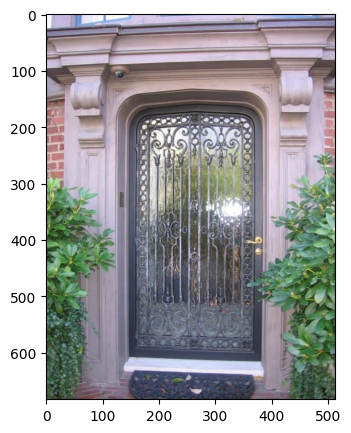

In [261]:
# Use random test image
# index = random.randint(0, len(test))
index=1
image = test[index]["image"].convert("RGB")
plt.figure(figsize=(15, 5))
plt.imshow(image)
target_size = image.size[::-1]
# Preprocess image
inputs = processor(images=image, return_tensors="pt").to(device)
# Inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)


In [262]:
print("Outputs...")
for key, value in outputs.items():
    print(f"  {key}: {value.shape}")

Outputs...
  class_queries_logits: torch.Size([1, 100, 101])
  masks_queries_logits: torch.Size([1, 100, 176, 128])
  encoder_last_hidden_state: torch.Size([1, 768, 22, 16])
  pixel_decoder_last_hidden_state: torch.Size([1, 256, 176, 128])
  transformer_decoder_last_hidden_state: torch.Size([1, 100, 256])


In [263]:
processor

MaskFormerFeatureExtractor {
  "_max_size": 2048,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "ignore_index": 255,
  "image_mean": [
    0.48500001430511475,
    0.4560000002384186,
    0.4059999883174896
  ],
  "image_processor_type": "MaskFormerFeatureExtractor",
  "image_std": [
    0.2290000021457672,
    0.2239999920129776,
    0.22499999403953552
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 2048,
    "shortest_edge": 512
  },
  "size_divisor": 32
}

In [264]:
# Post-process results to retrieve instance segmentation maps
result = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    target_sizes=[target_size]
)[0] # we pass a single output therefore we take the first result (single)
instance_seg_mask = result["segmentation"].cpu().detach().numpy()
print(f"Final mask shape: {instance_seg_mask.shape}")
print("Segments Information...")
for info in result["segments_info"]:
    print(f"  {info}")

Final mask shape: (683, 512)
Segments Information...


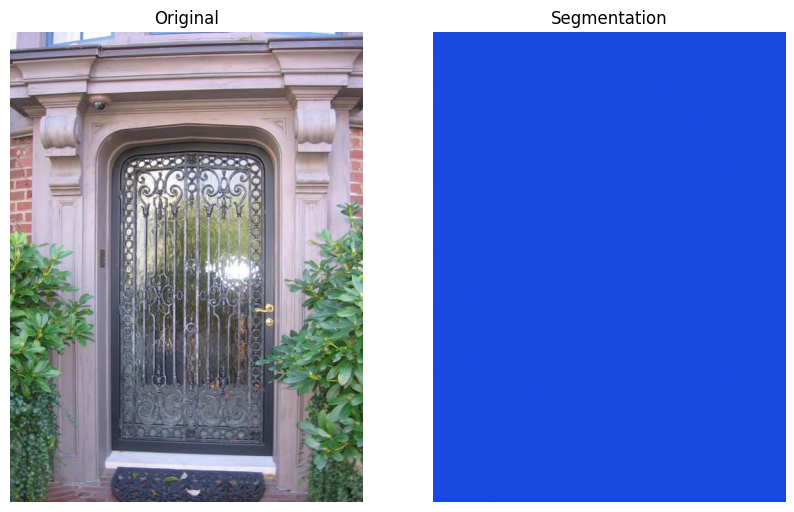

In [82]:
def visualize_instance_seg_mask(mask):
    # Initialize image with zeros with the image resolution
    # of the segmentation mask and 3 channels
    image = np.zeros((mask.shape[0], mask.shape[1], 3))
    # Create labels
    labels = np.unique(mask)
    label2color = {
        label: (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
        )
        for label in labels
    }
    for height in range(image.shape[0]):
        for width in range(image.shape[1]):
            image[height, width, :] = label2color[mask[height, width]]
    image = image / 255
    return image
instance_seg_mask_disp = visualize_instance_seg_mask(instance_seg_mask)
plt.figure(figsize=(10, 10))
for plot_index in range(2):
    if plot_index == 0:
        plot_image = image
        title = "Original"
    else:
        plot_image = instance_seg_mask_disp
        title = "Segmentation"

    plt.subplot(1, 2, plot_index+1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis("off")

In [ ]:
# Load Mean IoU metric
metrics = evaluate.load("mean_iou")
# Set model in evaluation mode
model.eval()
# Test set doesn't have annotations so we will use the validation set
ground_truths, preds = [], []
for idx in tqdm(range(200)):
    image = validation[idx]["image"].convert("RGB")
    target_size = image.size[::-1]
    # Get ground truth semantic segmentation map
    annotation = np.array(validation[idx]["annotation"])[:,:,0]
    # Replace null class (0) with the ignore_index (255) and reduce labels
    annotation -= 1
    annotation[annotation==-1] = 255
    ground_truths.append(annotation)
    # Preprocess image
    inputs = processor(images=image, return_tensors="pt").to(device)
    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process results to retrieve semantic segmentation maps
    result = processor.post_process_semantic_segmentation(outputs, target_sizes=[target_size])[0]
    semantic_seg_mask = result.cpu().detach().numpy()
    preds.append(semantic_seg_mask)
results = metrics.compute(
    predictions=preds,
    references=ground_truths,



SyntaxError: incomplete input (<ipython-input-13-39c2c88c5bce>, line 30)